<a href="https://colab.research.google.com/github/pelinsuciftcioglu/VAE/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Variational Auto-Encoder (VAE)**

VAE implementation inspired by:
- [Tomczak, J. M. (2021). Introduction to Deep Generative Modeling.](https://https://github.com/jmtomczak/intro_dgm)
- [CreativeAI: Deep Learning for Graphics Tutorial Code
](https://github.com/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb)







```
pip install --upgrade jupyter_http_over_ws>=0.0.7 && jupyter serverextension enable --py jupyter_http_over_ws

jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0
```



SVHN dataset: transform [-1, 1]

linear -> shunkk -> tanh for mu and logvar (maybe again a range for logvar again)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torch.utils
import torch.distributions
import torchvision
from torch import autograd  # TO USE "with autograd.detect_anomaly():"
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import scipy


import os

use_gpu = True

In [2]:
# CUSTOM TRANFORM FOR THE DATA WITHOUT NORMALIZING
"""
https://github.com/pytorch/vision/blob/a839796328cf4f789c9de5da0b3367b742b5a00c/torchvision/transforms/transforms.py

"""

import numbers
import warnings
from enum import Enum

from PIL import Image

from typing import List, Tuple, Any, Optional

try:
    import accimage
except ImportError:
    accimage = None

class ToTensor:
    def __call__(self, pic):
        """
        Args:
            pic (PIL Image or numpy.ndarray): Image to be converted to tensor.
        Returns:
            Tensor: Converted image.
        """
        return to_tensor(np.array(pic))

    def __repr__(self):
        return self.__class__.__name__ + '()'

def to_tensor(pic):
    """Convert a ``PIL Image`` or ``numpy.ndarray`` to tensor.
    This function does not support torchscript.
    See :class:`~torchvision.transforms.ToTensor` for more details.
    Args:
        pic (PIL Image or numpy.ndarray): Image to be converted to tensor.
    Returns:
        Tensor: Converted image.
    """
    default_float_dtype = torch.get_default_dtype()

    if isinstance(pic, np.ndarray):
        # handle numpy array
        if pic.ndim == 2:
            pic = pic[:, :, None]

        img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
        # backward compatibility
        if isinstance(img, torch.ByteTensor):
            return img.to(dtype=default_float_dtype)
        else:
            return img

    if accimage is not None and isinstance(pic, accimage.Image):
        nppic = np.zeros([pic.channels, pic.height, pic.width], dtype=np.float32)
        pic.copyto(nppic)
        return torch.from_numpy(nppic).to(dtype=default_float_dtype)

    # handle PIL Image
    mode_to_nptype = {'I': np.int32, 'I;16': np.int16, 'F': np.float32}
    img = torch.from_numpy(
        np.array(pic, mode_to_nptype.get(pic.mode, np.uint8), copy=True)
    )

    if pic.mode == '1':
        img = 255 * img
    img = img.view(pic.size[1], pic.size[0], len(pic.getbands()))
    # put it from HWC to CHW format
    img = img.permute((2, 0, 1)).contiguous()
    if isinstance(img, torch.ByteTensor):
        return img.to(dtype=default_float_dtype)
    else:
        return img

In [9]:
from torchvision.datasets import SVHN

train_dataloader = DataLoader(SVHN(root='./data/SVHN', download=True, split= 'train', transform=transforms.Compose([ToTensor()])), batch_size=64, shuffle=True)

  0%|          | 0/182040794 [00:00<?, ?it/s]

In [14]:
for i,j in train_dataloader:
  print(i.size(), j.size())

torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size

KeyboardInterrupt: ignored

In [5]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import MNIST
from torchvision.datasets import SVHN


def load_data_static(data_name, batch_size, is_binary = True, use_training_data_init = True):
    # set args
    if data_name == "MNIST":
      input_size = [1, 28, 28]
    else:
      input_size = []

    if is_binary:
      # start processing
      def lines_to_np_array(lines):
          return np.array([[int(i) for i in line.split()] for line in lines])
      with open(os.path.join('data', 'MNIST_static', 'binarized_mnist_train.amat')) as f:
          lines = f.readlines()
      x_train = lines_to_np_array(lines).astype('float32')
      with open(os.path.join('data', 'MNIST_static', 'binarized_mnist_valid.amat')) as f:
          lines = f.readlines()
      x_val = lines_to_np_array(lines).astype('float32')
      with open(os.path.join('data', 'MNIST_static', 'binarized_mnist_test.amat')) as f:
          lines = f.readlines()

      x_test = lines_to_np_array(lines).astype('float32')

      # shuffle train data
      np.random.shuffle(x_train)

      # idle y's
      y_train = np.zeros((x_train.shape[0], 1))
      y_val = np.zeros((x_val.shape[0], 1))
      y_test = np.zeros((x_test.shape[0], 1))


    else:
      if data_name == "MNIST":
        train_dataloader = DataLoader(MNIST(root='./data/MNIST', download=True, train=True, transform=transforms.Compose([ToTensor()])), batch_size=batch_size, shuffle=True)
        test_dataloader = DataLoader(MNIST('./data/MNIST', train=False, download=True, transform=transforms.Compose([ToTensor()])), batch_size=batch_size, shuffle=False)

        x_train = train_dataloader.dataset.data.float().numpy()
        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1] * x_train.shape[2] ) )

        y_train = np.array( train_dataloader.dataset.targets.float().numpy(), dtype=int)

        x_test = test_dataloader.dataset.data.float().numpy()
        x_test = np.reshape( x_test, (x_test.shape[0], x_test.shape[1] * x_test.shape[2] ) )

        y_test = np.array( test_dataloader.dataset.targets.float().numpy(), dtype=int)
      
      else:
        train_dataloader = DataLoader(SVHN(root='./data/SVHN', download=True, split= 'train', transform=transforms.Compose([ToTensor()])), batch_size=batch_size, shuffle=True)
        test_dataloader = DataLoader(SVHN(root='./data/SVHN', download=True, split= 'test', transform=transforms.Compose([ToTensor()])), batch_size=batch_size, shuffle=False)

        x_train = train_dataloader.dataset.data.float().numpy()
        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1] * x_train.shape[2] ) )

        y_train = np.array( train_dataloader.dataset.targets.float().numpy(), dtype=int)

        x_test = test_dataloader.dataset.data.float().numpy()
        x_test = np.reshape( x_test, (x_test.shape[0], x_test.shape[1] * x_test.shape[2] ) )

        y_test = np.array( test_dataloader.dataset.targets.float().numpy(), dtype=int)

      # validation set
      x_val = x_train[50000:60000]
      y_val = np.array(y_train[50000:60000], dtype=int)
      x_train = x_train[0:50000]
      y_train = np.array(y_train[0:50000], dtype=int)

    # pytorch data loader
    train = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
    train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)

    validation = TensorDataset(torch.from_numpy(x_val).float(), torch.from_numpy(y_val))
    val_dataloader = DataLoader(validation, batch_size=batch_size, shuffle=False)

    test = TensorDataset(torch.from_numpy(x_test).float(), torch.from_numpy(y_test))
    test_dataloader = DataLoader(test, batch_size=batch_size, shuffle=True)

    return [train, validation, test], train_dataloader, val_dataloader, test_dataloader

In [ ]:
class_names = ['Zero', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine']

def plot_data(file_name, num_images, images, labels=None, is_binary=True, reconstructed=False):
  
  color = "gray_r"
  
  if reconstructed:
    if not is_binary:
      color = "gray"
      images = torch.ceil(images * 255)

  if is_binary:
    labels = None

  images = images.cpu()

  images = images.detach().numpy()

  grid = math.ceil(math.sqrt(num_images))
  plt.figure(figsize=(grid*2,grid*2))
  for i in range(num_images):
      plt.subplot(grid,grid,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)     
      plt.imshow(images[i].reshape(28,28), cmap=color)
      if labels != None:
        plt.xlabel(class_names[labels[i]])      
  plt.savefig(file_name)
  plt.close()

In [ ]:
PI = torch.from_numpy(np.asarray(np.pi))
EPS = 1.e-5

# DISTRBUTION FOR THE DATA (INPUT)

def log_categorical(x, x_new, num_classes, reduction=None, dim=None):
    x_one_hot = F.one_hot(x.long(), num_classes)
    log_p = x_one_hot * torch.log(torch.clamp(x_new, EPS, 1. - EPS))
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        # 32 x 784 x 256
        return torch.sum(log_p, dim)
        # 32 x 784
    else:
        return log_p

def log_bernoulli(x, x_new, reduction=None, dim=None):
    x_new = torch.clamp(x_new, EPS, 1. - EPS)
    log_p = x * torch.log(x_new) + (1. - x) * torch.log(1. - x_new)
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p

# DISTRIBUTION FOR THE VARIATIONAL INFERENCE

def log_normal_diag(x, mu, log_var, reduction=None, dim=None):
    D = x.shape[1]
    log_p = -0.5 * D * torch.log(2. * PI) - 0.5 * log_var - 0.5 * torch.exp(-log_var) * (x - mu)**2.
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p


# PRIOR DISTRIBUTIONS for p(z)

def log_standard_normal(x, reduction=None, dim=None):
    D = x.shape[1]
    log_p = -0.5 * D * torch.log(2. * PI) - 0.5 * x**2.
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p


# Chakraborty & Chakravarty, "A new discrete probability distribution with integer support on (−∞, ∞)",
#  Communications in Statistics - Theory and Methods, 45:2, 492-505, DOI: 10.1080/03610926.2013.830743

def log_min_exp(a, b, epsilon=1e-8):
    """
    Source: https://github.com/jornpeters/integer_discrete_flows
    Computes the log of exp(a) - exp(b) in a (more) numerically stable fashion.
    Using:
    log(exp(a) - exp(b))
    c + log(exp(a-c) - exp(b-c))
    a + log(1 - exp(b-a))
    And note that we assume b < a always.
    """
    y = a + torch.log(1 - torch.exp(b - a) + epsilon)

    return y

def log_integer_probability(x, mean, logscale):
    scale = torch.exp(logscale)

    logp = log_min_exp(
      F.logsigmoid((x + 0.5 - mean) / scale),
      F.logsigmoid((x - 0.5 - mean) / scale))

    return logp

def log_integer_probability_standard(x):
    logp = log_min_exp(
      F.logsigmoid(x + 0.5),
      F.logsigmoid(x - 0.5))

    return logp

In [ ]:
class Encoder(nn.Module):
    def __init__(self, D, H, L):
        super(Encoder, self).__init__()

        self.encoder_net = nn.Sequential(nn.Linear(D, H), nn.LeakyReLU(), nn.Linear(H, H), nn.LeakyReLU(), nn.Linear(H, 2*L))

    def encode(self, x):
      # Flatten the input to a single dimension
      x = (torch.flatten(x, start_dim=1)).to(device)

      mu, log_var = self.forward(x)

      return x, mu, log_var

    def forward(self, x):
      x = x.to(device)

      h = self.encoder_net(x)

      # Split the neural network output for means and log variances
      mu, log_var =  torch.chunk(h, 2, dim=1)
      return mu, log_var

    def sample(self, mu, log_var):
      std = torch.exp(0.5 * log_var)
      # Sample epsilon ~ N(0,I)
      eps = torch.randn_like(std)
      # Reparameterization trick
      z = mu + eps * std
      return z

    def log_prob(self, mu, log_var, z):
      return log_normal_diag(z, mu, log_var)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, D, H, L, distribution, num_vals):
        super(Decoder, self).__init__()
        self.D = D
        self.distribution = distribution
        self.num_vals = num_vals

        self.decoder_net = nn.Sequential(nn.Linear(L, H), nn.LeakyReLU(), nn.Linear(H, H), nn.LeakyReLU(), nn.Linear(H, D * num_vals))

    def decode(self, z):
      x_new = self.forward(z)

      return x_new

    def forward(self, z):
      x_new = self.decoder_net(z)
      
      if self.distribution == 'categorical':
        b = x_new.shape[0]
        d = self.D
        x_new = x_new.reshape(b, d, self.num_vals)
        return torch.softmax(x_new, 2)
      
      elif self.distribution == 'bernoulli':
        return torch.sigmoid(x_new)

    def sample(self, z):
        x_generated = self.decode(z)

        if self.distribution == 'categorical':
            b = x_generated.shape[0]
            m = x_generated.shape[1]
            x_generated = x_generated.view(b, -1, self.num_vals)
            p = x_generated.view(-1, self.num_vals)
            x_generated = torch.multinomial(p, num_samples=1).view(b, m)
        elif self.distribution == 'bernoulli':
            x_generated = torch.bernoulli(x_generated)

        return x_generated

In [ ]:
class StandardPrior(nn.Module):
    def __init__(self, L):
        super(StandardPrior, self).__init__()
        self.L = L
        self.means = torch.zeros(1, L)
        self.log_vars = torch.zeros(1, L)

    def sample(self, batch_size):
        z = torch.randn((batch_size, self.L))
        return z

    def log_prob(self, z):
        return log_standard_normal(z)

In [ ]:
class MoGPrior(nn.Module):
  def __init__(self, L, num_components):
    super(MoGPrior, self).__init__()

    self.L = L
    self.num_components = num_components

    self.means = torch.randn(num_components, self.L).to(device)
    self.log_vars = torch.randn(num_components, self.L).to(device)
    
    self.w = torch.zeros(num_components, 1, 1).to(device)

  def sample(self, batch_size):
    # mu, lof_var

    # mixing probabilities
    w = F.softmax(self.w, dim=0)
    w = w.squeeze()

    # pick components
    indexes = torch.multinomial(w, batch_size, replacement=True)

    # means and logvars
    eps = torch.randn(batch_size, self.L).to(device)
    for i in range(batch_size):
        indx = indexes[i]
        if i == 0:
            z = self.means[[indx]] + eps[[i]] * torch.exp(self.log_vars[[indx]])
        else:
            z = torch.cat((z, self.means[[indx]] + eps[[i]] * torch.exp(self.log_vars[[indx]])), 0)
    return z

  def log_prob(self, z):
    # mu, lof_var

    # mixing probabilities
    w = F.softmax(self.w, dim=0)

    # log-mixture-of-Gaussians
    z = z.unsqueeze(0) # 1 x B x L
    means = self.means.unsqueeze(1) # K x 1 x L
    log_vars = self.log_vars.unsqueeze(1) # K x 1 x L

    log_p = log_normal_diag(z, means, log_vars) + torch.log(w) # K x B x L
    log_prob = torch.logsumexp(log_p, dim=0, keepdim=False) # B x L

    return log_prob


In [ ]:
class FlowPrior(nn.Module):
    def __init__(self, nets, nett, num_flows, D=2):
        super(FlowPrior, self).__init__()

        self.D = D

        self.t = torch.nn.ModuleList([nett() for _ in range(num_flows)])
        self.s = torch.nn.ModuleList([nets() for _ in range(num_flows)])
        self.num_flows = num_flows

    def coupling(self, x, index, forward=True):
        (xa, xb) = torch.chunk(x, 2, 1)

        s = self.s[index](xa)
        t = self.t[index](xa)

        if forward:
            #yb = f^{-1}(x)
            yb = (xb - t) * torch.exp(-s)
        else:
            #xb = f(y)
            yb = torch.exp(s) * xb + t

        return torch.cat((xa, yb), 1), s

    def permute(self, x):
        return x.flip(1)

    def f(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in range(self.num_flows):
            z, s = self.coupling(z, i, forward=True)
            z = self.permute(z)
            log_det_J = log_det_J - s.sum(dim=1)

        return z, log_det_J

    def f_inv(self, z):
        x = z
        for i in reversed(range(self.num_flows)):
            x = self.permute(x)
            x, _ = self.coupling(x, i, forward=False)

        return x

    def sample(self, batch_size):
        z = torch.randn(batch_size, self.D)
        x = self.f_inv(z)
        return x.view(-1, self.D)

    def log_prob(self, x):
        z, log_det_J = self.f(x)
        log_p = (log_standard_normal(z) + log_det_J.unsqueeze(1))
        return log_p

In [ ]:
class GTMPrior(nn.Module):
    def __init__(self, L, gtm_net, num_components, u_min=-1., u_max=1.):
        super(GTMPrior, self).__init__()

        self.L = L

        # 2D manifold
        self.u = torch.zeros(num_components**2, 2).to(device) # K**2 x 2
        u1 = torch.linspace(u_min, u_max, steps=num_components).to(device)
        u2 = torch.linspace(u_min, u_max, steps=num_components).to(device)

        k = 0
        for i in range(num_components):
            for j in range(num_components):
                self.u[k,0] = u1[i]
                self.u[k,1] = u2[j]
                k = k + 1

        # gtm network: u -> z
        self.gtm_net = gtm_net

        # mixing weights
        self.w = nn.Parameter(torch.zeros(num_components**2, 1, 1))

    def get_params(self):
        # u->z
        h_gtm = self.gtm_net(self.u) #K**2 x 2L
        mean_gtm, logvar_gtm = torch.chunk(h_gtm, 2, dim=1) # K**2 x L and K**2 x L
        # Hardtanh -7/-5 to 1/2
        #boundary_mu = nn.Tanh()
        #boundary_logvar = nn.Hardtanh(-5, 1)

        #mean_gtm = boundary_mu(mean_gtm)
        #logvar_gtm = boundary_mu(logvar_gtm)

        #print("Mean:", mean_gtm, "max and min:", torch.max(mean_gtm), torch.min(mean_gtm))
        #print("Log-var:", logvar_gtm, "max and min:", torch.max(logvar_gtm), torch.min(logvar_gtm))
        return mean_gtm, logvar_gtm

    def sample(self, batch_size):
        # u->z
        mean_gtm, logvar_gtm = self.get_params()

        # mixing probabilities
        w = F.softmax(self.w, dim=0)
        w = w.squeeze()

        # pick components
        indexes = torch.multinomial(w, batch_size, replacement=True)

        # means and logvars
        eps = torch.randn(batch_size, self.L).to(device)
        for i in range(batch_size):
            indx = indexes[i]
            if i == 0:
                z = mean_gtm[[indx]] + eps[[i]] * torch.exp(logvar_gtm[[indx]])
            else:
                z = torch.cat((z, mean_gtm[[indx]] + eps[[i]] * torch.exp(logvar_gtm[[indx]])), 0)
        return z

    def log_prob(self, z):
        # u->z
        mean_gtm, logvar_gtm = self.get_params()
        #print("z:", z, "max and min:", torch.max(z), torch.min(z))
        
        # log-mixture-of-Gaussians
        z = z.unsqueeze(0) # 1 x B x L
        mean_gtm = mean_gtm.unsqueeze(1) # K**2 x 1 x L
        logvar_gtm = logvar_gtm.unsqueeze(1) # K**2 x 1 x L

        w = F.softmax(self.w, dim=0)

        log_p = log_normal_diag(z, mean_gtm, logvar_gtm) + torch.log(w) # K**2 x B x L
        log_prob = torch.logsumexp(log_p, dim=0, keepdim=False) # B x L

        return log_prob

In [ ]:
class VampPrior(nn.Module):
  def __init__(self, L, D, num_vals, encoder, num_components, data=None):
    super(VampPrior, self).__init__()

    self.L = L
    self.D = D
    self.num_vals = num_vals

    self.encoder = encoder

    # pseudoinputs
    u = torch.rand(num_components, D) * self.num_vals
    self.u = nn.Parameter(u)

    # mixing weights
    self.w = nn.Parameter(torch.zeros(self.u.shape[0], 1, 1)) # K x 1 x 1

  def get_params(self):
    # u->encoder->mu, lof_var
    x, mean_vampprior, logvar_vampprior = self.encoder.encode(self.u) #(K x L), (K x L)
    return mean_vampprior, logvar_vampprior

  def sample(self, batch_size):
    # u->encoder->mu, lof_var
    mean_vampprior, logvar_vampprior = self.get_params()

    # mixing probabilities
    w = F.softmax(self.w, dim=0) # K x 1 x 1 
    w = w.squeeze()

    # pick components
    indexes = torch.multinomial(w, batch_size, replacement=True)

    # means and logvars
    eps = (torch.randn(batch_size, self.L)).to(device)
    for i in range(batch_size):
      indx = indexes[i]
      if i == 0:
        z = mean_vampprior[[indx]] + eps[[i]] * torch.exp(logvar_vampprior[[indx]])
      else:
        z = torch.cat((z, mean_vampprior[[indx]] + eps[[i]] * torch.exp(logvar_vampprior[[indx]])), 0)
    return z

  def log_prob(self, z):
    # u->encoder->mu, lof_var
    mean_vampprior, logvar_vampprior = self.get_params() # (K x L) & (K x L)

    # mixing probabilities
    w = F.softmax(self.w, dim=0) # K x 1 x 1

    # log-mixture-of-Gaussians
    z = z.unsqueeze(0) # 1 x B x L
    mean_vampprior = mean_vampprior.unsqueeze(1) # K x 1 x L
    logvar_vampprior = logvar_vampprior.unsqueeze(1) # K x 1 x L

    log_p = log_normal_diag(z, mean_vampprior, logvar_vampprior) + torch.log(w) # K x B x L
    log_prob = torch.logsumexp(log_p, dim=0, keepdim=False) # B x L

    return log_prob # B

In [ ]:
class GTMVampPrior(nn.Module):
    def __init__(self, L, D, gtm_net, encoder, num_points, u_min=-10., u_max=10., num_vals=255):
        super(GTMVampPrior, self).__init__()

        self.L = L
        self.D = D
        self.num_vals = num_vals

        self.encoder = encoder

        # 2D manifold
        self.u = torch.zeros(num_points**2, 2).to(device) # K**2 x 2
        u1 = torch.linspace(u_min, u_max, steps=num_points)
        u2 = torch.linspace(u_min, u_max, steps=num_points)

        k = 0
        for i in range(num_points):
            for j in range(num_points):
                self.u[k,0] = u1[i]
                self.u[k,1] = u2[j]
                k = k + 1

        # gtm network: u -> x
        self.gtm_net = gtm_net

        # mixing weights
        self.w = nn.Parameter(torch.zeros(num_points**2, 1, 1))

    def get_params(self):
        # u->gtm_net->u_x
        h_gtm = self.gtm_net(self.u) #K x D
        h_gtm = h_gtm * self.num_vals
        # u_x->encoder->mu, lof_var
        x, mean_vampprior, logvar_vampprior = self.encoder.encode(h_gtm) #(K x L), (K x L)
        return mean_vampprior, logvar_vampprior

    def sample(self, batch_size):
        # u->encoder->mu, lof_var
        mean_vampprior, logvar_vampprior = self.get_params()

        # mixing probabilities
        w = F.softmax(self.w, dim=0)
        w = w.squeeze()

        # pick components
        indexes = torch.multinomial(w, batch_size, replacement=True)

        # means and logvars
        eps = torch.randn(batch_size, self.L).to(device)
        for i in range(batch_size):
            indx = indexes[i]
            if i == 0:
                z = mean_vampprior[[indx]] + eps[[i]] * torch.exp(logvar_vampprior[[indx]])
            else:
                z = torch.cat((z, mean_vampprior[[indx]] + eps[[i]] * torch.exp(logvar_vampprior[[indx]])), 0)
        return z

    def log_prob(self, z):
        # u->encoder->mu, lof_var
        mean_vampprior, logvar_vampprior = self.get_params()

        # mixing probabilities
        w = F.softmax(self.w, dim=0)

        # log-mixture-of-Gaussians
        z = z.unsqueeze(0) # 1 x B x L
        mean_vampprior = mean_vampprior.unsqueeze(1) # K x 1 x L
        logvar_vampprior = logvar_vampprior.unsqueeze(1) # K x 1 x L

        log_p = log_normal_diag(z, mean_vampprior, logvar_vampprior) + torch.log(w) # K x B x L
        log_prob = torch.logsumexp(log_p, dim=0, keepdim=False) # B x L

        return log_prob

In [ ]:
class VAE(nn.Module):
  def __init__(self, D, H, L, distribution, num_vals, prior):
        super(VAE, self).__init__()
        self.encoder = Encoder(D, H, L)
        self.decoder = Decoder(D, H, L, distribution, num_vals)
        self.prior = prior


        self.num_vals = num_vals
        self.distribution = distribution
  
  def forward(self, x, reduction='avg'):
        
        x, mu, log_var = self.encoder.encode(x)

        # Sample z based on the mean and log variance
        z = self.encoder.sample(mu, log_var)

        # Decode the latent representation and reconstruct input
        x_new = self.decoder.decode(z)

        # Reconstructed images based on the highest probability assigned for each pixel
        if (self.distribution == 'categorical'):
          x_reconstructed, idx = torch.max(x_new, dim=2)
        else:
          x_reconstructed = torch.bernoulli(x_new)

        # Evidence Lower Bound
        ELBO = self.loss(x, x_new, z, mu, log_var, reduction)

        return x_reconstructed, ELBO
  
  def loss(self, x, x_new, z, mu, log_var, reduction='avg'):
    # Reconstruction Error
    RE = self.log_prob(x, x_new)
    # KL-Divergence
    KL = (self.prior.log_prob(z) - self.encoder.log_prob(mu, log_var, z)).sum(-1)
    #print("prior log prob: ",self.prior.log_prob(z), "encoder log prob", self.encoder.log_prob(mu, log_var, z))
    #print("KL:", KL)
    if reduction == 'sum':
      # For testing sum all the loss values in the batch then take the average in the training loop
      return -(RE + KL).sum() 
    else:
      # For training calculate the mean of the loss values of the batch
      return -(RE + KL).mean()


  def log_prob(self, x, x_new):

    if self.distribution == 'categorical':
      log_prob = log_categorical(x, x_new, self.num_vals, reduction='sum', dim=-1).sum(-1)  # (32)

    elif self.distribution == 'bernoulli':
      log_prob = log_bernoulli(x, x_new, reduction='sum', dim=-1)

    return log_prob

  def sample(self, batch_size=128):
    z = self.prior.sample(batch_size=batch_size)

    z = z.to(device)  # FOR GENERATING SAMPLES

    return self.decoder.sample(z)

In [ ]:
# DISTRUBUTION FOR THE INPUT DATA
likelihood_type = 'bernoulli'

if likelihood_type == 'categorical':
    num_vals = 256
    is_binary = False
elif likelihood_type == 'bernoulli':
    num_vals = 1
    is_binary = True

prior_distribution = 'vampprior'

if prior_distribution in ['standard', 'flow']:
    num_components = 1
elif prior_distribution[0:3] == 'gtm':
    num_components = 16
else:
    num_components = 28**2

In [ ]:
D = 28*28 # INPUT DATA DIMENSIONALITY
H = 256   # HIDDEN LAYER NODES
L = 32    # LATENT VARIABLES DIMENSIONALITY

learning_rate = 0.0001
num_epochs = 100

batch_size = 32
data_set = "MNIST"

In [ ]:
data, train_dataloader, val_dataloader, test_dataloader = load_data_static(data_set, batch_size, is_binary)

train_data, val_data, test_data = data

device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")

In [ ]:
encoder = Encoder(D,H,L).to(device)

if prior_distribution == 'gtm':
    gtm_net = nn.Sequential(nn.Linear(2, H), nn.Tanh(),
                          nn.Linear(H, H), nn.Tanh(),
                          nn.Linear(H, 2 * L))

    prior = GTMPrior(L=L, gtm_net=gtm_net, num_components=num_components, u_min=-10., u_max=10.)

elif prior_distribution == 'vampprior':
    prior = VampPrior(L=L, D=D, num_vals=num_vals, encoder=encoder, num_components=num_components).to(device)

elif prior_distribution == 'data-vampprior-avg':
    prior = VampPrior(L=L, D=D, num_vals=num_vals, encoder=encoder, num_components=num_components, data=torch.from_numpy(np.mean(train_data, 0, keepdims=True)))

elif prior_distribution == 'data-vampprior-raw':
    prior = VampPrior(L=L, D=D, num_vals=num_vals, encoder=encoder, num_components=num_components, data=torch.from_numpy(train_data[:num_components]))

elif prior_distribution == 'gtm-vampprior':
    gtm_net_vamp = nn.Sequential(nn.Linear(2, H), nn.Tanh(),
                          nn.Linear(H, H), nn.Tanh(),
                          nn.Linear(H, D), nn.Sigmoid())
    prior = GTMVampPrior(L=L, D=D, gtm_net=gtm_net_vamp, encoder=encoder, num_points=num_components, u_min=-10., u_max=10., num_vals=num_vals)

elif prior_distribution == 'mog':
    prior = MoGPrior(L=L, num_components=num_components)

elif prior_distribution == 'standard':
    prior = StandardPrior(L=L)

elif prior_distribution == 'flow':
    num_flows = 3

    # scale (s) network
    nets = lambda: nn.Sequential(nn.Linear(L // 2, H), nn.LeakyReLU(),
                                nn.Linear(H, H), nn.LeakyReLU(),
                                nn.Linear(H, L // 2), nn.Tanh())

    # translation (t) network
    nett = lambda: nn.Sequential(nn.Linear(L // 2, H), nn.LeakyReLU(),
                                nn.Linear(H, H), nn.LeakyReLU(),
                                nn.Linear(H, L // 2))

    prior = FlowPrior(nets, nett, num_flows=num_flows, D=L)

In [ ]:
model = VAE(D, H, L, likelihood_type, num_vals, prior)

model = model.to(device)

# ADAM OPTIMIZER
optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad == True], lr=learning_rate)

In [ ]:
results_dir = 'Results/'
if not(os.path.exists(results_dir)):
    os.mkdir(results_dir)

model_name = 'VAE_' + prior_distribution

name = results_dir + model_name

In [ ]:
def generate_samples(name, extra_name=None, num_samples=16):
  
  model_best = torch.load(name + '.model')

  model_best = model_best.to(device)

  model_best.eval()

  x = torch.tensor(0, device=device)

  x = model_best.sample(num_samples)

  x = x.cpu()

  plot_data(name + '_Generated_images' + extra_name, num_samples, x)  

In [ ]:
train_loss_avgs = []
val_loss_avgs = []
best_loss = 1000.

num_samples = 16
epochs_sample = [5, 25, 50, 75, 100]

print("Training...")

for epoch in range(1, num_epochs+1):
  model.train()

  train_loss_avgs.append(0)
  num_batches = 0
  for batch_idx, (data, labels) in enumerate(train_dataloader, 1):
      
    data = data.to(device)

    x_reconstructed, loss = model.forward(data)

    optimizer.zero_grad()
    loss.backward(retain_graph=True)    
    optimizer.step()

    train_loss_avgs[-1] += loss.item()
    num_batches += 1

    if (batch_idx == random.randint(0, len(train_dataloader))) and (epoch in epochs_sample):    #random.randint(0, len(train_dataloader)):
      plot_data(name + "_Reconstructed_images_epoch_" + str(epoch) + "_batch_" + str(batch_idx), num_samples, x_reconstructed, labels, is_binary, reconstructed=True)

  train_loss_avgs[-1] /= num_batches
  
  model.eval()
  val_loss_avgs.append(0)
  N = 0.
  for batch_idx_val, (data_val, labels_val) in enumerate(val_dataloader, 1):
    data_val.to(device)
    x_reconstructed_val, loss_val = model.forward(data_val, reduction='sum')
      
    if batch_idx_val == random.randint(0, len(val_dataloader)) and (epoch in epochs_sample):
      plot_data(name + "_Reconstructed_images_validation_epoch_" + str(epoch) + "_batch_" + str(batch_idx), num_samples, x_reconstructed_val, is_binary=is_binary, reconstructed=True)
    
    val_loss_avgs[-1] += loss_val.item()
    N = N + data_val.shape[0]
    
  val_loss_avgs[-1] /= N
  
  print('Epoch [%d / %d]: Average training loss: %f, Average validation loss: %f' % (epoch, num_epochs, train_loss_avgs[-1], val_loss_avgs[-1]))
  
  if epoch == 1:
    print('Model Saved!')
    torch.save(model, name + '.model')
    best_loss = train_loss_avgs[-1]

  else:
    if train_loss_avgs[-1] < best_loss:
      print('Model Saved!')
      torch.save(model, name + '.model')
      best_loss = train_loss_avgs[-1]

      if epoch in epochs_sample:
        generate_samples(name, "_epoch_" + str(epoch), num_samples)


Training...
Epoch [1 / 100]: Average training loss: 212.065735, Average validation loss: 188.325003
Model Saved!
Epoch [2 / 100]: Average training loss: 173.154070, Average validation loss: 156.851146
Model Saved!
Epoch [3 / 100]: Average training loss: 149.931444, Average validation loss: 143.881305
Model Saved!
Epoch [4 / 100]: Average training loss: 139.060848, Average validation loss: 135.474142
Model Saved!
Epoch [5 / 100]: Average training loss: 132.335412, Average validation loss: 130.017916
Model Saved!
Epoch [6 / 100]: Average training loss: 127.948389, Average validation loss: 126.184100
Model Saved!
Epoch [7 / 100]: Average training loss: 124.434892, Average validation loss: 122.954097
Model Saved!
Epoch [8 / 100]: Average training loss: 121.695271, Average validation loss: 120.695152
Model Saved!
Epoch [9 / 100]: Average training loss: 119.613007, Average validation loss: 118.839744
Model Saved!
Epoch [10 / 100]: Average training loss: 117.908409, Average validation loss: 1

In [ ]:
model_best = torch.load(name + '.model')

model_best = model_best.to(device)

# set to evaluation mode
model_best.eval()

test_loss, num_batches = 0, 0
num_samples = 16

for batch_idx_test, (test_data, test_labels) in enumerate(test_dataloader, 1):
    
  test_data = test_data.to(device)  

  x_reconstructed, loss = model_best.forward(test_data, reduction='sum')

  if batch_idx_test == 20:
    plot_data(name + '_Real_images_test_data' + str(batch_idx_test), num_samples, test_data, test_labels)
    plot_data(name + "_Reconstructed_images_test_data_batch_" + str(batch_idx_test), 16, x_reconstructed, test_labels, is_binary, reconstructed=True)
    generate_samples(name, "_test_data_batch_" + str(batch_idx_test), num_samples=num_samples)

  test_loss += loss.item()
  num_batches = num_batches + test_data.shape[0]
    
test_loss /= num_batches
print('Average test loss: %f' % (test_loss))

Average test loss: 96.446523


In [ ]:
batch_num = 522

for batch_idx, (data, labels) in enumerate(train_dataloader, 1):
  
  data = data.to(device)

  if batch_idx == batch_num:
      plot_data(name + "_Real_images_train_data" + "_batch_" + str(batch_idx), 16, data, labels)

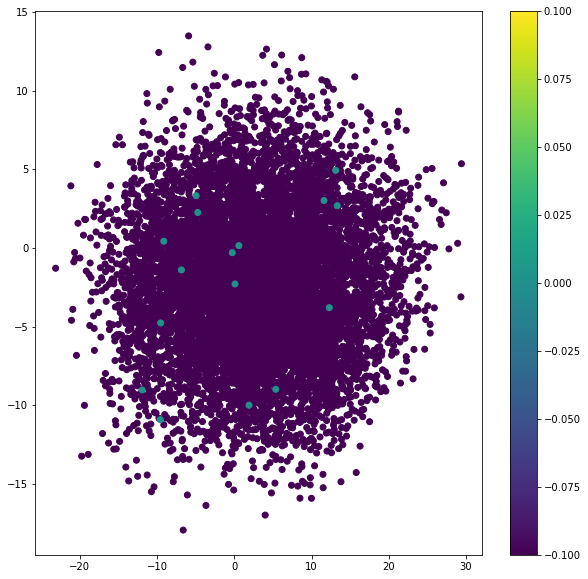

In [ ]:
#imgs, labels = next(iter(test_dataloader))
plt.figure(figsize=(10, 10))

for imgs, labels in test_dataloader:
  img = imgs.to(device)
  x, x_encoded_mean, x_encoded_log_var = model.encoder.encode(imgs)

  x_encoded_mean = x_encoded_mean.cpu().detach().numpy()
  plt.scatter(x_encoded_mean[:,0], x_encoded_mean[:,1], c=labels)

plt.colorbar()
plt.savefig("encoding.png")

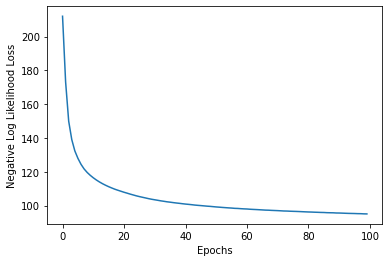

[212.06573490233126, 173.15406993590176, 149.93144376416734, 139.0608480530371, 132.33541182837118, 127.94838878609626, 124.43489150854539, 121.69527096055825, 119.61300713361568, 117.90840899662108, 116.43116003660079, 115.12426214529319, 113.96767243954591, 112.93145349738084, 112.00999167571065, 111.16604361409037, 110.40124942733169, 109.67780265881325, 109.0538393485569, 108.45916486899974, 107.86514616592221, 107.3342354274757, 106.7697222582133, 106.26298172963558, 105.74753196164727, 105.30051005748473, 104.89241316313935, 104.4919989568182, 104.07640443729882, 103.71484672268156, 103.4064951754501, 103.09823604493437, 102.77069061533122, 102.50091847561905, 102.2119726863185, 101.9939462828926, 101.73671706792108, 101.5099638623453, 101.30753999052334, 101.07614228485947, 100.86533876054195, 100.69429693142726, 100.50641230353162, 100.28207061630903, 100.11854817298308, 99.96802125858788, 99.80440865368395, 99.63561651482463, 99.50845777690982, 99.33662581001423, 99.1676658928

In [ ]:
# plt.ion()

fig = plt.figure()
plt.plot(train_loss_avgs)
plt.xlabel('Epochs')
plt.ylabel('Negative Log Likelihood Loss')
plt.show()

print(train_loss_avgs)

In [ ]:
f = open(name + '_Model_Description.txt', "w")

f.write("VAE \n---------------------------------\n"
        "- Dataset: " + "MNIST" + "\n"+
        "- Batch Size: "+ str(batch_size) + "\n"+
        "- Likelihood: "+ likelihood_type + "\n"+
        "- Prior Distribution: "+ prior_distribution + "\n"
        "- Number of Values: "+ str(num_vals) + "\n"+
        "- Number of Latents: " + str(L) + "\n\n"+
        "Model:\n" + str(model) + "\n\n"+
        "Optimizer:\n"+ str(optimizer) + "\n"+
        "- Number of Epochs: "+ str(num_epochs) + "\n\n"+
        "Results:\n-------------------------------\n"
        "- Average Training Loss: " + "{:.2f}".format(train_loss_avgs[-1]) + "\n"+
        "- Average Validation Loss: " + "{:.2f}".format(val_loss_avgs[-1]) + "\n"+
        "- Average Test Loss: " + "{:.2f}".format(test_loss))
f.close()

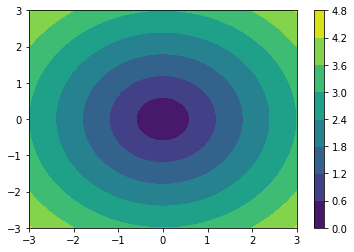

In [ ]:
xlist = np.linspace(-3.0, 3.0, 100)
ylist = np.linspace(-3.0, 3.0, 100)
X, Y = np.meshgrid(xlist, ylist)

Z = np.sqrt(X**2 + Y**2)

fig,ax=plt.subplots(1,1)

cp = ax.contourf(X, Y, Z)
fig.colorbar(cp) # Add a colorbar to a plot
plt.show()